In [ ]:
import torch
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [ ]:
%load_ext autoreload
%autoreload 2

from llm.data import load_dataset, text_to_tensor, tensor_to_text
from llm.training import ReccurentLMTrainingLoop, TrainingLogs
# from llm.rnn import CharRNN
from llm.lstm import CharLSTM

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

In [4]:
(train_dataset, valid_dataset), ctoi, itoc = load_dataset(
    Path("dataset", "lotr.txt"), slice(0, 2_000_000), slice(2_000_000, None)
)

print(f"Train dataset length:      {len(train_dataset)} characters")
print(f"Validation dataset length: {len(valid_dataset)} characters")

Train dataset length:      2000000 characters
Validation dataset length: 579949 characters


In [5]:
# model = CharRNN(vocab_size=len(ctoi), embedding_dim=16, hidden_dim=64, num_layers=1)
model = CharLSTM(vocab_size=len(ctoi), embedding_dim=16, hidden_dim=64, num_layers=2)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

CharLSTM(
  (embedding): Embedding(96, 16)
  (lstm): LSTM(16, 64, num_layers=2)
  (linear): Linear(in_features=64, out_features=96, bias=True)
)
Number of parameters: 62048


In [6]:
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience=25)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
n_epochs = 1000
sequence_length = 256
batch_size = 32
# batch_size = 16

training_loop = ReccurentLMTrainingLoop(
    device, n_epochs, sequence_length, batch_size,
    train_dataset, valid_dataset,
    model, optimizer, scheduler
)

with TrainingLogs() as logs:
    training_loop.run(logs)

Training on device cuda
epoch     0/999: train loss = 3.142889, valid loss = 2.930825, learning rate = 0.001
epoch   100/999: train loss = 1.296100, valid loss = 1.353212, learning rate = 0.001
epoch   200/999: train loss = 1.235189, valid loss = 1.307492, learning rate = 0.001
epoch   300/999: train loss = 1.210473, valid loss = 1.289009, learning rate = 0.001
epoch   400/999: train loss = 1.194166, valid loss = 1.285540, learning rate = 0.001
epoch   500/999: train loss = 1.183624, valid loss = 1.278435, learning rate = 0.001
epoch   600/999: train loss = 1.176707, valid loss = 1.273378, learning rate = 0.001
epoch   700/999: train loss = 1.168678, valid loss = 1.270043, learning rate = 0.0005120000000000001
epoch   800/999: train loss = 1.164924, valid loss = 1.269693, learning rate = 0.0004096000000000001
epoch   900/999: train loss = 1.161868, valid loss = 1.267129, learning rate = 0.0002621440000000001
epoch   999/999: train loss = 1.159625, valid loss = 1.266068, learning rate =

In [8]:
def display_training_review(train_losses, valid_losses=None, learning_rates=None):
    fig, ax = plt.subplots()

    ax.set_title("Cross entropy over the epochs")
    ax.plot(train_losses, label="train loss")
    if valid_losses is not None:
        ax.plot(valid_losses, label="valid loss")
        best_valid_epoch = np.argmin(valid_losses)
        best_valid = valid_losses[best_valid_epoch]
        ax.plot(best_valid_epoch, best_valid, 'or')
        ax.text(best_valid_epoch, best_valid, f"({best_valid_epoch}, {best_valid:.6f})", ha='center', va='top', color='red')
    ax.legend(loc='upper right')
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.grid()

    if learning_rates is not None:
        lr_ax = ax.twinx()
        lr_ax.plot(learning_rates, ':r', label='learning rate')
        lr_ax.set_xlabel("epoch")
        lr_ax.set_ylabel("learning rate")
        lr_ax.legend(loc='lower left')

    fig.tight_layout()
    plt.show()

Training time: 522 seconds


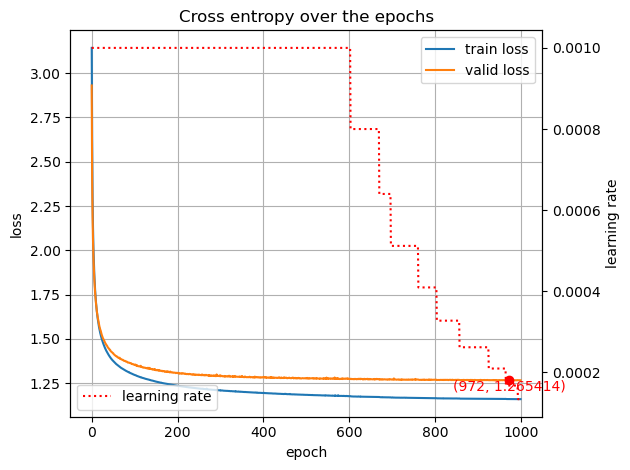

In [9]:
print(f"Training time: {logs.ellapsed_time:.0f} seconds")
display_training_review(logs.train_loss, logs.valid_loss, logs.lr)

In [10]:
def print_prediction_examples(model, test_contexts, n_predictions=80, repeat=4):
    model.eval()

    with torch.no_grad():
        print("Deterministic predictions:")
        for context in test_contexts:
            context_tokens = text_to_tensor(context, ctoi)
            predicted_tokens = model.predict_argmax(context_tokens, n_predictions)
            predicted_text = tensor_to_text(predicted_tokens, itoc)
            print(f"{repr(context)} -> {repr(predicted_text)}")

        print("\nProbabilistic predictions:")
        for context in test_contexts:
            for _ in range(repeat):
                predicted_tokens = model.predict_proba(context_tokens, n_predictions)
                predicted_text = tensor_to_text(predicted_tokens, itoc)
                print(f"{repr(context)} -> {repr(predicted_text)}")

In [15]:
test_contexts = (
    "The throne",
    "Aragorn son of",
    "He paused, ",
    "the ring of ",
    "suddenly",
    "you cannot ",
    "I am a servant of the Secret Fire",
)
model.to(cpu)
model.eval()
print_prediction_examples(model, test_contexts, 80)

Deterministic predictions:
'The throne' -> ' was still and straight to the stone of the stone. The water was still and strai'
'Aragorn son of' -> ' Denethor the world that we shall have the stream that was the stone of the Ring'
'He paused, ' -> 'and the stone of the water and the stone of the stone of the stone of the stone '
'the ring of ' -> 'the stone of the stone. The water was still and straight to the stone of the sto'
'suddenly' -> ' and strange to the stone. The water was still and strange the stone of the ston'
'you cannot ' -> 'eye the stone of the stone of the stone of the stone of the stone of the stone o'
'I am a servant of the Secret Fire' -> '. The water was still and straight to the stone of the stone. The water was stil'

Probabilistic predictions:
'The throne' -> "d; to their gates. 'With perish the day was a prent, poor merry_ our love in sof"
'The throne' -> "d. 'I opened to me?'\n     'I am as I can pregont a steps?' he said, as if he_s t"
'The throne' -> ". Gorni